In [11]:
import os
from multiprocessing import Pool
from functools import partial

import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import numpy.linalg as la
from scipy.sparse import csc_matrix, csr_matrix
from tqdm.auto import tqdm

from datasets import get_dataset
from first_order import Ig, Nesterov
from loss_functions import Quadratic
from stochastic_first_order import Sgd, Shuffling, ClippedShuffling
from utils import get_trace, relative_round
%load_ext autoreload
%autoreload 2

import matplotlib
sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.figsize'] = (8, 6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# %%html
# <style>
# .cell-output-ipywidget-background {
#    background-color: transparent !important;
# }
# .jp-OutputArea-output {
#    background-color: transparent;
# }  
# .jupyter-widgets {color: #d5d5d5 !important;}
# .widget-label {color: #d5d5d5 !important;}
# </style>

# Functions spread on the edges of interval

In [13]:
dataset = 'quadratic'
x = np.append(np.arange(0, 501), np.arange(1e5 - 500, 1e5 + 1))
np.random.seed(0)
x = np.append(np.random.randint(0, 501, 500), 
              np.random.randint(1e5 - 500, 1e5 + 1, 500))
loss = Quadratic(x)
n, dim = len(x), 1
L = loss.smoothness()
# x0 = csc_matrix((dim, 1))
x0 = np.array([1e4])
n_epoch = 600
batch_size = 32
# n_seeds = 2 # was set to 20 in the paper
n_seeds = 10
stoch_it = 250 * n // batch_size
trace_len = 300
trace_path = f'results/{dataset}/'
step_size_list = np.logspace(-3, 0, 4)
# clip_level_list = np.logspace(-3, 3, 7)
clip_level_list = np.logspace(1, 7, 7)
pool = Pool(7)
step_size_list, clip_level_list

(array([0.001, 0.01 , 0.1  , 1.   ]),
 array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07]))

In [14]:
f_opt = loss.f_opt
x_opt = loss.x_opt
f_opt, x_opt

(2475213799266.8643, 49999.444)

In [15]:
def best_trace_by_step_size(traces, step_size_list):
    min_i, min_val = 0, np.inf
    for i, tr in enumerate(traces):
        if tr.loss_vals is None:
            mean_loss_val = 0
            for loss_vals in tr.loss_vals_all.values():
                mean_loss_val += loss_vals[-1]
            mean_loss_val /= len(tr.loss_vals_all)
        else:
            mean_loss_val = tr.loss_vals[-1]
        if mean_loss_val < min_val:
            min_val = mean_loss_val
            min_i = i
    
    best_trace = traces[min_i]
    best_trace.step_size = step_size_list[min_i]
    return best_trace

## Experiments

Random Reshuffling

In [16]:
rr_traces = []
for step_size in tqdm(step_size_list):
    rr_lr0 = step_size
    rr = Shuffling(
        loss=loss, 
        lr0=rr_lr0, 
        it_max=stoch_it, 
        n_seeds=n_seeds, 
        batch_size=batch_size, 
        trace_len=trace_len
    )
    rr_trace = rr.run(x0=x0)
    rr_trace.convert_its_to_epochs(batch_size=batch_size)
    rr_trace.compute_loss_of_iterates()
    rr_traces.append(rr_trace)
rr_trace = best_trace_by_step_size(rr_traces, step_size_list)
print(f'Best step size: {rr_trace.step_size}')

  0%|          | 0/4 [00:00<?, ?it/s]

Best step size: 0.001


In [17]:
rr_trace.save('rr', trace_path)

Clipped random reshuffling

In [18]:
crr_traces = []
for clip_level in tqdm(clip_level_list):
    cl_crr_traces = []
    for step_size in step_size_list:
        crr_lr0 = step_size
        crr = ClippedShuffling(
            loss=loss, 
            lr0=crr_lr0, 
            it_max=stoch_it, 
            n_seeds=n_seeds, 
            batch_size=batch_size, 
            trace_len=trace_len,
            clip_level=clip_level,
            steps_per_permutation=np.inf
        )
        crr_trace = crr.run(x0=x0)
        crr_trace.convert_its_to_epochs(batch_size=batch_size)
        crr_trace.compute_loss_of_iterates()
        crr_trace.compute_last_iterate_grad_norms()
        cl_crr_traces.append(crr_trace)
    
    best_trace = best_trace_by_step_size(cl_crr_traces, step_size_list)
    crr_traces.append(best_trace)
for cl, trace in zip(clip_level_list, crr_traces):
    print(f'Best step size for clip level {cl}: {trace.step_size}')

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
for cl, trace in zip(clip_level_list, crr_traces):
    print(f'Best step size for clip level {cl}: {trace.step_size}')

Best step size for clip level 0.001: 1.0
Best step size for clip level 0.01: 1.0
Best step size for clip level 0.1: 1.0
Best step size for clip level 1.0: 1.0
Best step size for clip level 10.0: 1.0
Best step size for clip level 100.0: 1.0
Best step size for clip level 1000.0: 0.1


In [ ]:
for clip_level, crr_trace in zip(clip_level_list, crr_traces):
    crr_trace.save(f'c_{clip_level}_rr', trace_path)

Clipped random reshuffling Opt

In [ ]:
crr_opt_traces = []
for clip_level in tqdm(clip_level_list):
    cl_crr_opt_traces = []
    for step_size in step_size_list:
        crr_opt_lr0 = step_size
        crr_opt = ClippedShuffling(
            loss=loss, 
            lr0=crr_opt_lr0, 
            it_max=stoch_it, 
            n_seeds=n_seeds, 
            batch_size=batch_size, 
            trace_len=trace_len,
            clip_level=clip_level,
            x_opt=x_opt,
            steps_per_permutation=np.inf
        )
        crr_opt_trace = crr_opt.run(x0=x0)
        crr_opt_trace.convert_its_to_epochs(batch_size=batch_size)
        crr_opt_trace.compute_loss_of_iterates()
        crr_opt_trace.compute_last_iterate_grad_norms()
        cl_crr_opt_traces.append(crr_opt_trace)
    
    best_trace = best_trace_by_step_size(cl_crr_opt_traces, step_size_list)
    crr_opt_traces.append(best_trace)

for cl, trace in zip(clip_level_list, crr_opt_traces):
    print(f'Best step size for clip level {cl}: {trace.step_size}')

  0%|          | 0/7 [00:00<?, ?it/s]

Best step size for clip level 0.001: 0.001
Best step size for clip level 0.01: 0.001
Best step size for clip level 0.1: 0.001
Best step size for clip level 1.0: 0.001
Best step size for clip level 10.0: 1.0
Best step size for clip level 100.0: 1.0
Best step size for clip level 1000.0: 0.1


In [ ]:
crr_opt_traces[-1].loss.stochastic_gradient(x_opt, )

In [ ]:
for clip_level, crr_opt_trace in zip(clip_level_list, crr_opt_traces):
    crr_opt_trace.save(f'c_{clip_level}_opt_rr', trace_path)

Clipping with shifts

In [ ]:
alpha_shift_list = step_size_list
a_crr_shift_traces_dict = {}
for alpha_shift in tqdm(alpha_shift_list):
    a_crr_shift_traces_dict[alpha_shift] = []
    for clip_level in clip_level_list:
        cl_crr_shift_traces = []

        for step_size in step_size_list:
            crr_shift_lr0 = step_size
            crr_shift = ClippedShuffling(
                loss=loss, 
                lr0=crr_shift_lr0, 
                it_max=stoch_it, 
                n_seeds=n_seeds, 
                batch_size=batch_size, 
                trace_len=trace_len,
                clip_level=clip_level,
                alpha_shift=alpha_shift,
                steps_per_permutation=np.inf
            )
            crr_shift_trace = crr_shift.run(x0=x0)
            crr_shift_trace.convert_its_to_epochs(batch_size=batch_size)
            crr_shift_trace.compute_loss_of_iterates()
            crr_shift_trace.compute_last_iterate_grad_norms()
            cl_crr_shift_traces.append(crr_shift_trace)

        best_trace = best_trace_by_step_size(cl_crr_shift_traces, step_size_list)
        a_crr_shift_traces_dict[alpha_shift].append(best_trace)

for alpha, cl_crr_shift_traces in a_crr_shift_traces_dict.items():
    for cl, trace in zip(clip_level_list, cl_crr_shift_traces):
        print(f'Best step size for alpha {alpha}, clip level {cl}: {trace.step_size}')

  0%|          | 0/4 [00:00<?, ?it/s]

Best step size for alpha 0.001, clip level 0.001: 1.0
Best step size for alpha 0.001, clip level 0.01: 1.0
Best step size for alpha 0.001, clip level 0.1: 1.0
Best step size for alpha 0.001, clip level 1.0: 1.0
Best step size for alpha 0.001, clip level 10.0: 1.0
Best step size for alpha 0.001, clip level 100.0: 1.0
Best step size for alpha 0.001, clip level 1000.0: 1.0
Best step size for alpha 0.01, clip level 0.001: 1.0
Best step size for alpha 0.01, clip level 0.01: 1.0
Best step size for alpha 0.01, clip level 0.1: 1.0
Best step size for alpha 0.01, clip level 1.0: 1.0
Best step size for alpha 0.01, clip level 10.0: 1.0
Best step size for alpha 0.01, clip level 100.0: 1.0
Best step size for alpha 0.01, clip level 1000.0: 1.0
Best step size for alpha 0.1, clip level 0.001: 1.0
Best step size for alpha 0.1, clip level 0.01: 1.0
Best step size for alpha 0.1, clip level 0.1: 1.0
Best step size for alpha 0.1, clip level 1.0: 1.0
Best step size for alpha 0.1, clip level 10.0: 0.1
Best st

In [ ]:
for alpha_shift in a_crr_shift_traces_dict:
    for clip_level, crr_trace in zip(clip_level_list, a_crr_shift_traces_dict[alpha_shift]):
        crr_trace.save(f'c_{clip_level}_a_shift_{alpha_shift}_rr', trace_path)

Single reshuffling

In [ ]:
so_traces = []
for step_size in tqdm(step_size_list):
    so_lr0 = step_size
    so = Shuffling(
        loss=loss, 
        lr0=so_lr0, 
        it_max=stoch_it, 
        n_seeds=n_seeds, 
        batch_size=batch_size, 
        steps_per_permutation=np.inf, 
        trace_len=trace_len
    )
    so_trace = so.run(x0=x0)
    so_trace.convert_its_to_epochs(batch_size=batch_size)
    so_trace.compute_loss_of_iterates()
    so_traces.append(so_trace)
so_trace = best_trace_by_step_size(so_traces, step_size_list)
print(f'best step size: {so_trace.step_size}')

  0%|          | 0/4 [00:00<?, ?it/s]

best step size: 0.01


In [ ]:
so_trace.save('so', trace_path)

SGD

In [ ]:
sgd_traces = []
for step_size in tqdm(step_size_list):
    sgd_lr0 = step_size
    sgd = Sgd(
        loss=loss,
        lr0=sgd_lr0, 
        it_max=stoch_it, 
        n_seeds=1, 
        batch_size=batch_size, 
        avoid_cache_miss=True, 
        trace_len=trace_len
    )
    sgd_trace = sgd.run(x0=x0)
    sgd_trace.convert_its_to_epochs(batch_size=batch_size)
    sgd_trace.compute_loss_of_iterates()
    sgd_traces.append(sgd_trace)
sgd_trace = best_trace_by_step_size(sgd_traces, step_size_list)
print(f'best step size: {sgd_trace.step_size}')

  0%|          | 0/4 [00:00<?, ?it/s]

best step size: 0.01


In [ ]:
sgd_trace.save('sgd', trace_path)

Deterministic reshuffling

In [ ]:
ig_traces = []
for step_size in tqdm(step_size_list):
    ig_lr0 = step_size
    ig = Ig(
        loss=loss, 
        lr0=ig_lr0, 
        it_max=stoch_it, 
        batch_size=batch_size, 
        trace_len=trace_len
    )
    ig_trace = ig.run(x0=x0)
    ig_trace.convert_its_to_epochs(batch_size=batch_size)
    ig_trace.compute_loss_of_iterates()
    ig_traces.append(ig_trace)
ig_trace = best_trace_by_step_size(ig_traces, step_size_list)
print(f'best step size: {ig_trace.step_size}')

  0%|          | 0/4 [00:00<?, ?it/s]

best step size: 0.01


In [ ]:
ig_trace.save('ig', trace_path)

## Plots

In [21]:
ncols = 2 if len(clip_level_list) >= 2 else 1
nrows = int(np.ceil(len(clip_level_list) / 2))
fig_x = 18
fig_y = 28

### Everything with CRR without shifts

#### Functional residual

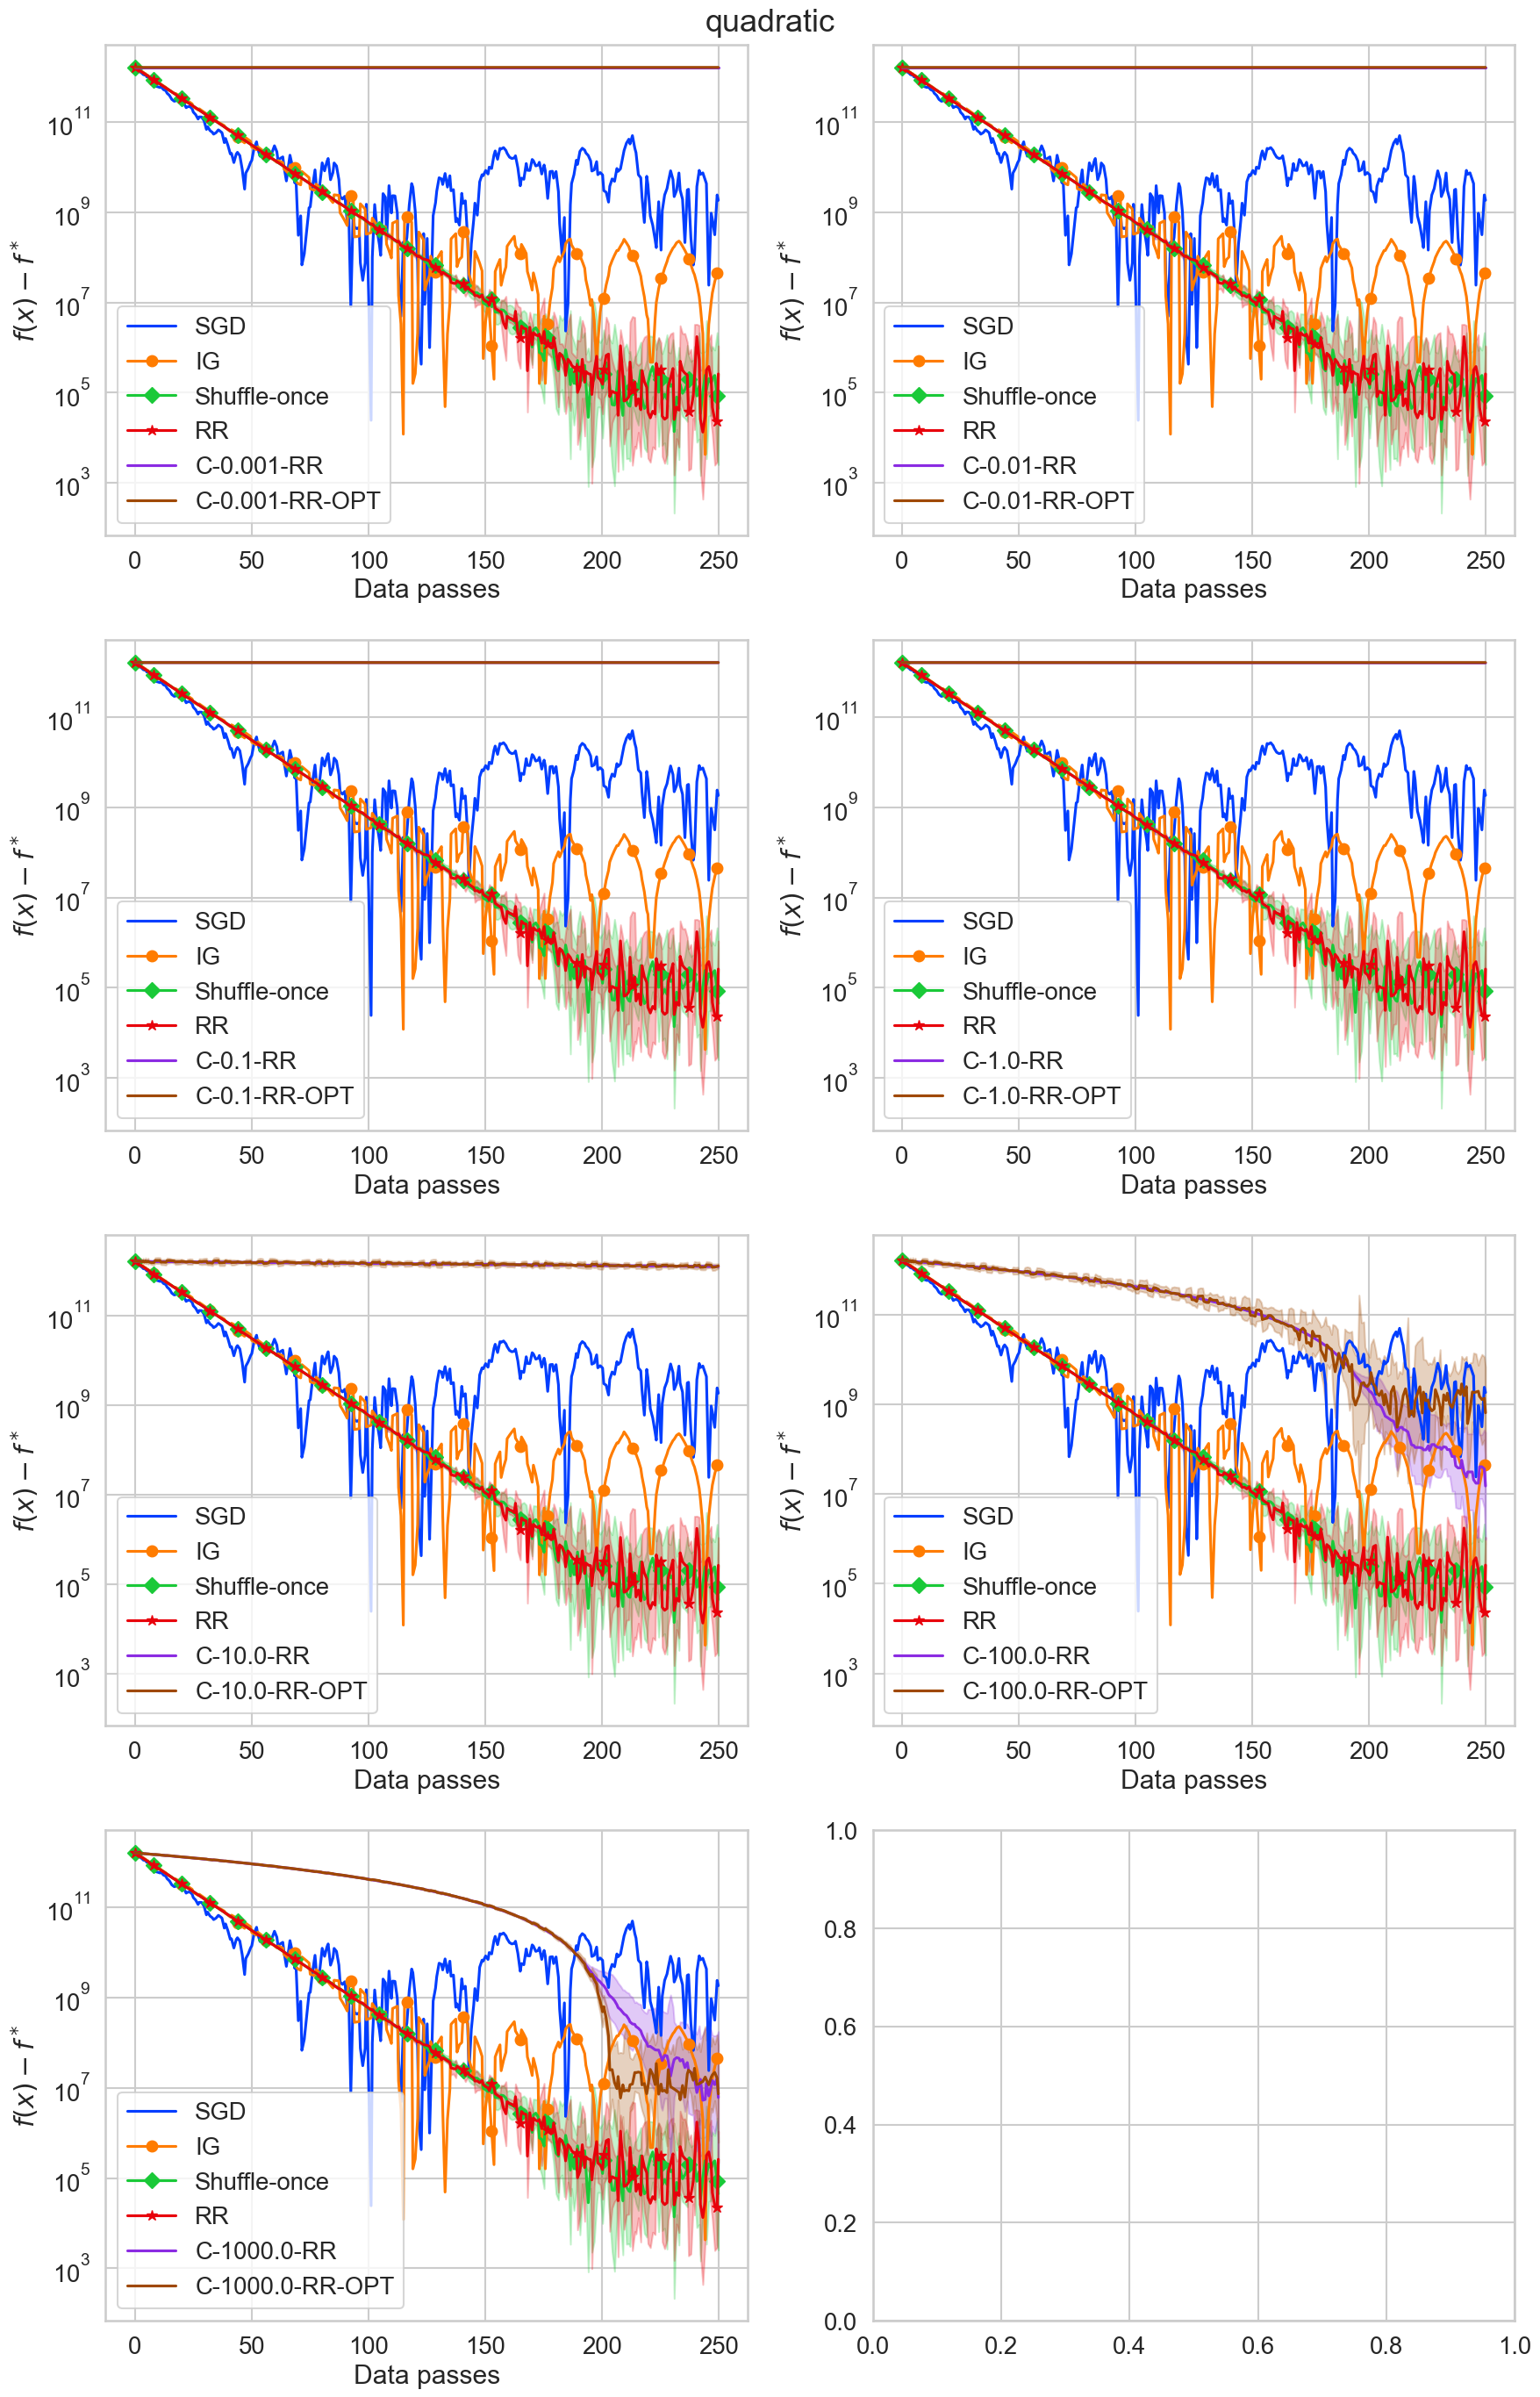

In [22]:
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_x, fig_y))
for ax, c_rr_trace, c_rr_opt_trace, clip_level in zip(axis.flatten(), crr_traces, crr_opt_traces, clip_level_list):
    traces = [sgd_trace, ig_trace, so_trace, rr_trace, c_rr_trace, c_rr_opt_trace]
    labels = ['SGD', 'IG', 'Shuffle-once', 'RR', f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', 'o', 'D', '*', ',', ',']
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_losses(f_opt=f_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
# plt.savefig(f'./plots/{dataset}/{dataset}/_func.png', dpi=300)

#### Distance to solution

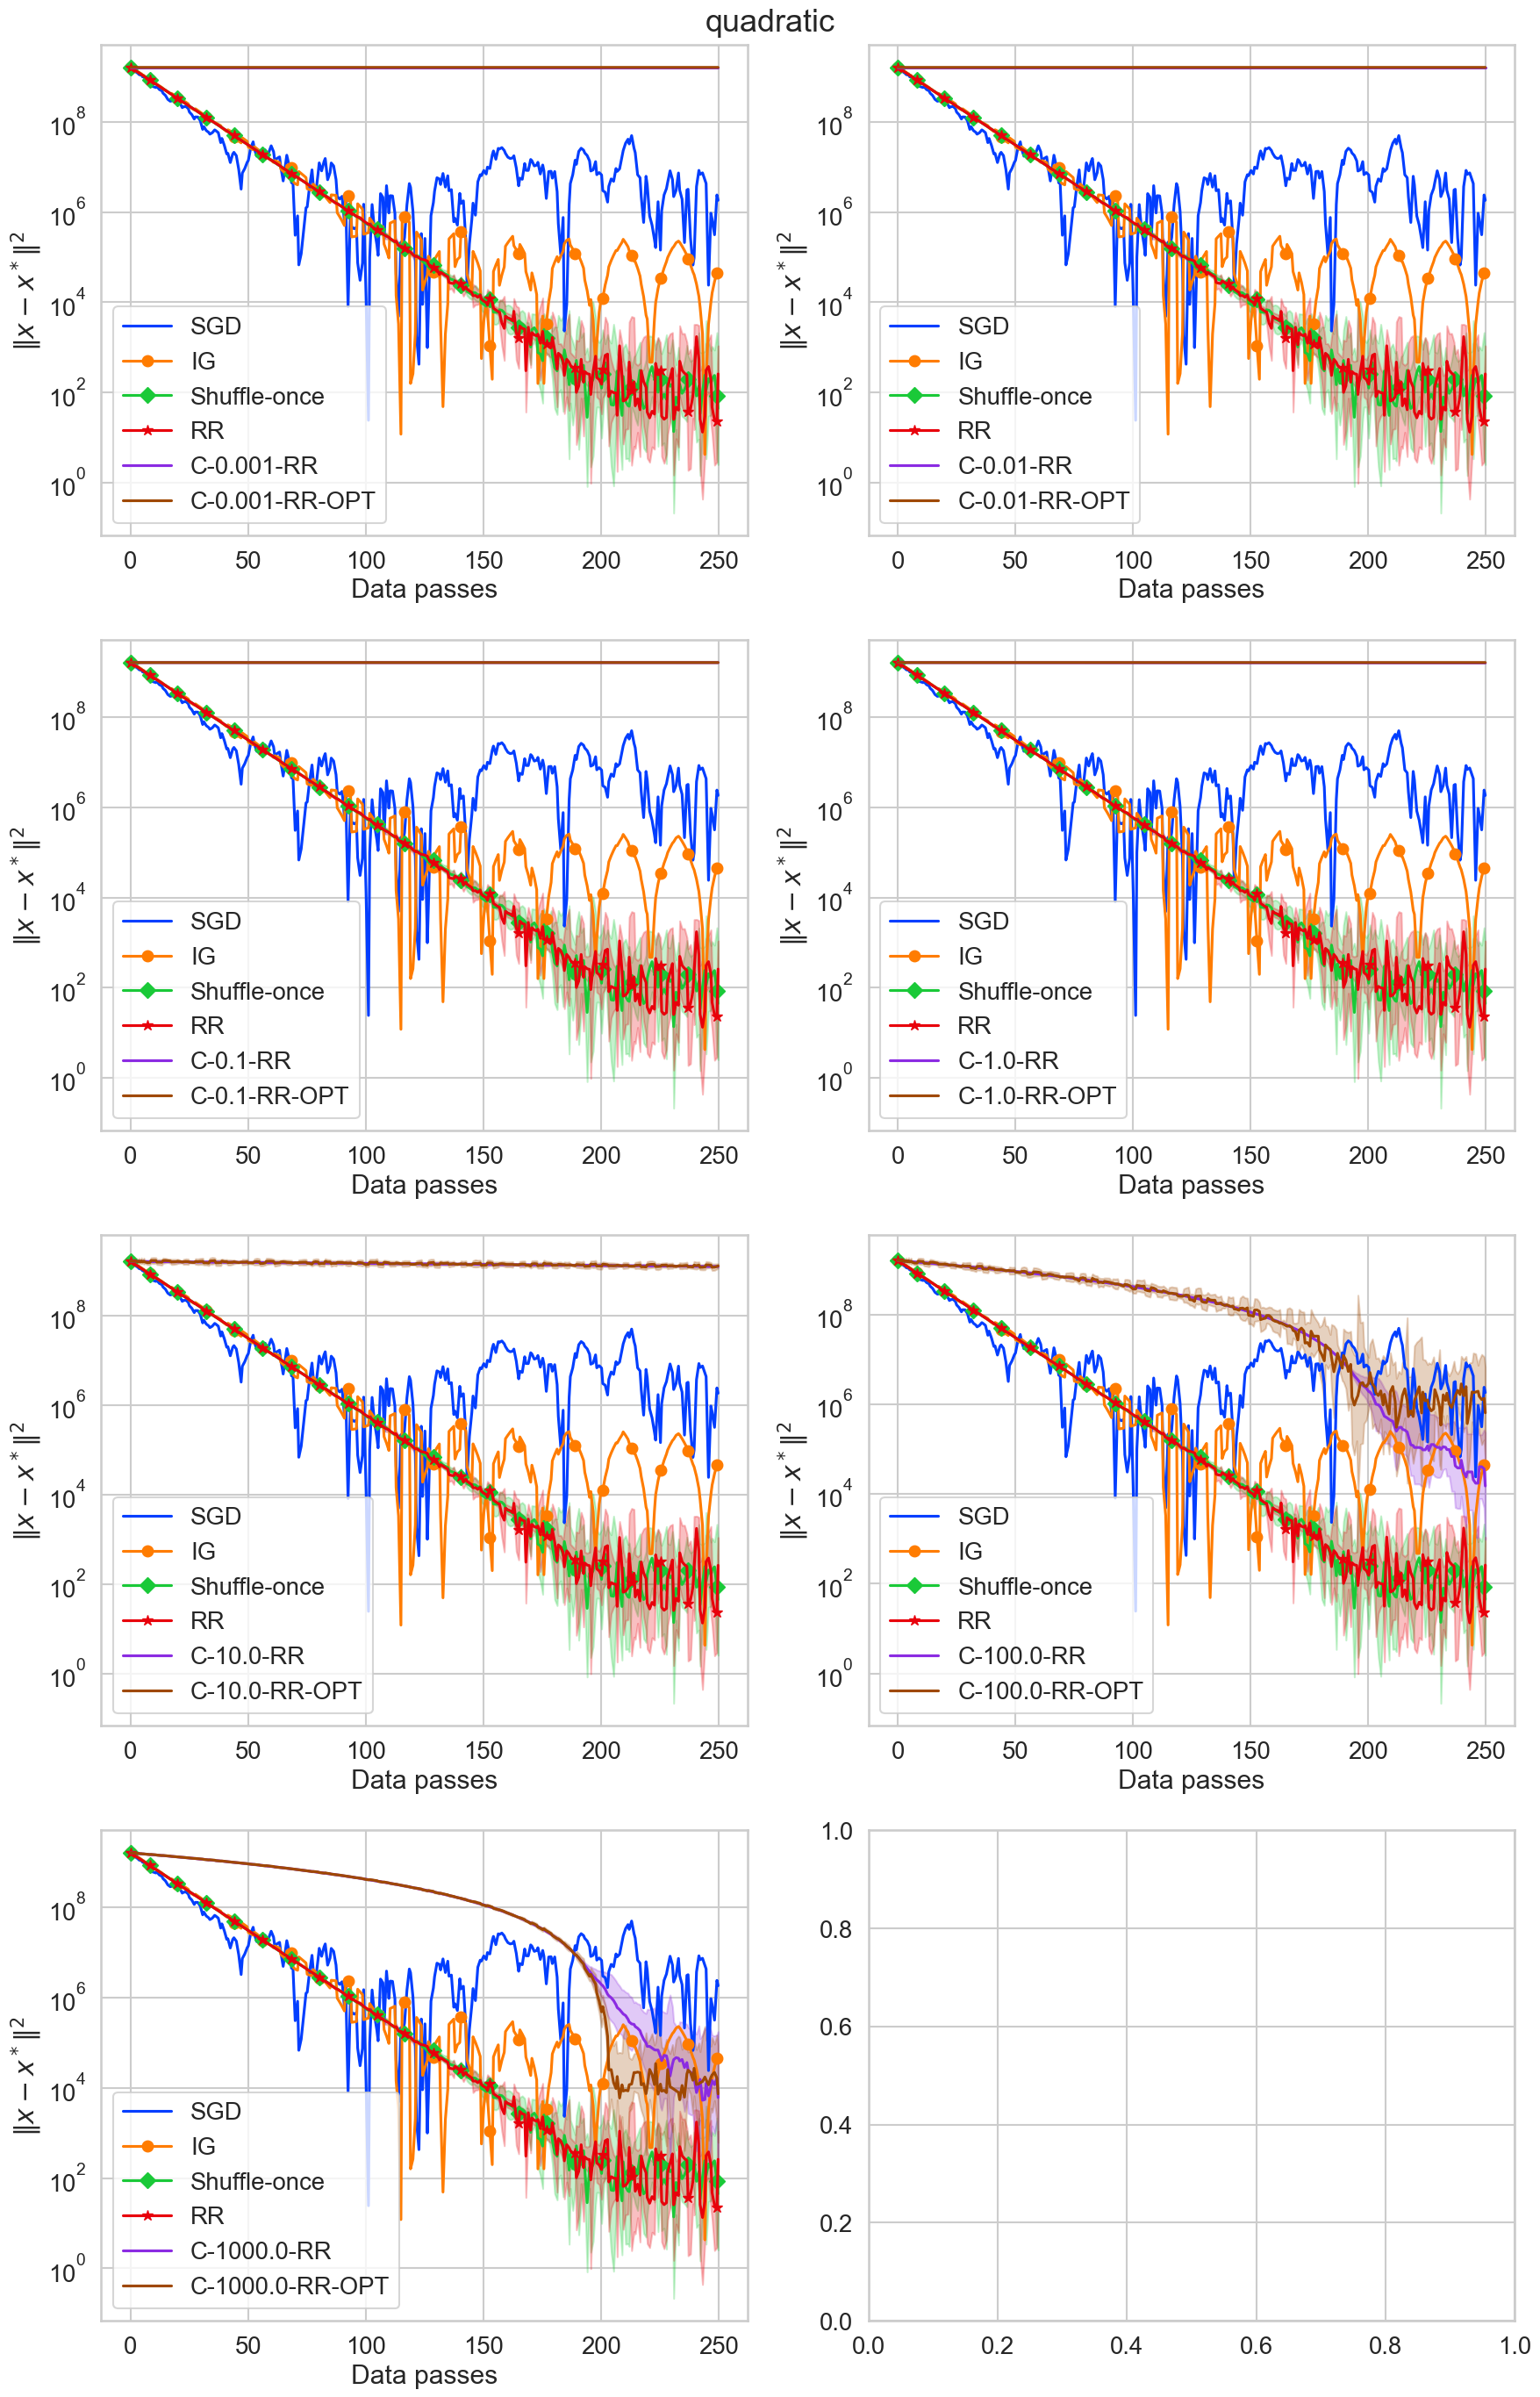

In [23]:
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_x, fig_y))
for ax, c_rr_trace, c_rr_opt_trace, clip_level in zip(axis.flatten(), crr_traces, crr_opt_traces, clip_level_list):
    traces = [sgd_trace, ig_trace, so_trace, rr_trace, c_rr_trace, c_rr_opt_trace]
    labels = ['SGD', 'IG', 'Shuffle-once', 'RR', f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', 'o', 'D', '*', ',', ',']
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_distances(x_opt=x_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
# plt.savefig(f'./plots/{dataset}/{dataset}_dist.png', dpi=300)

### Only CRR

#### Functional residual

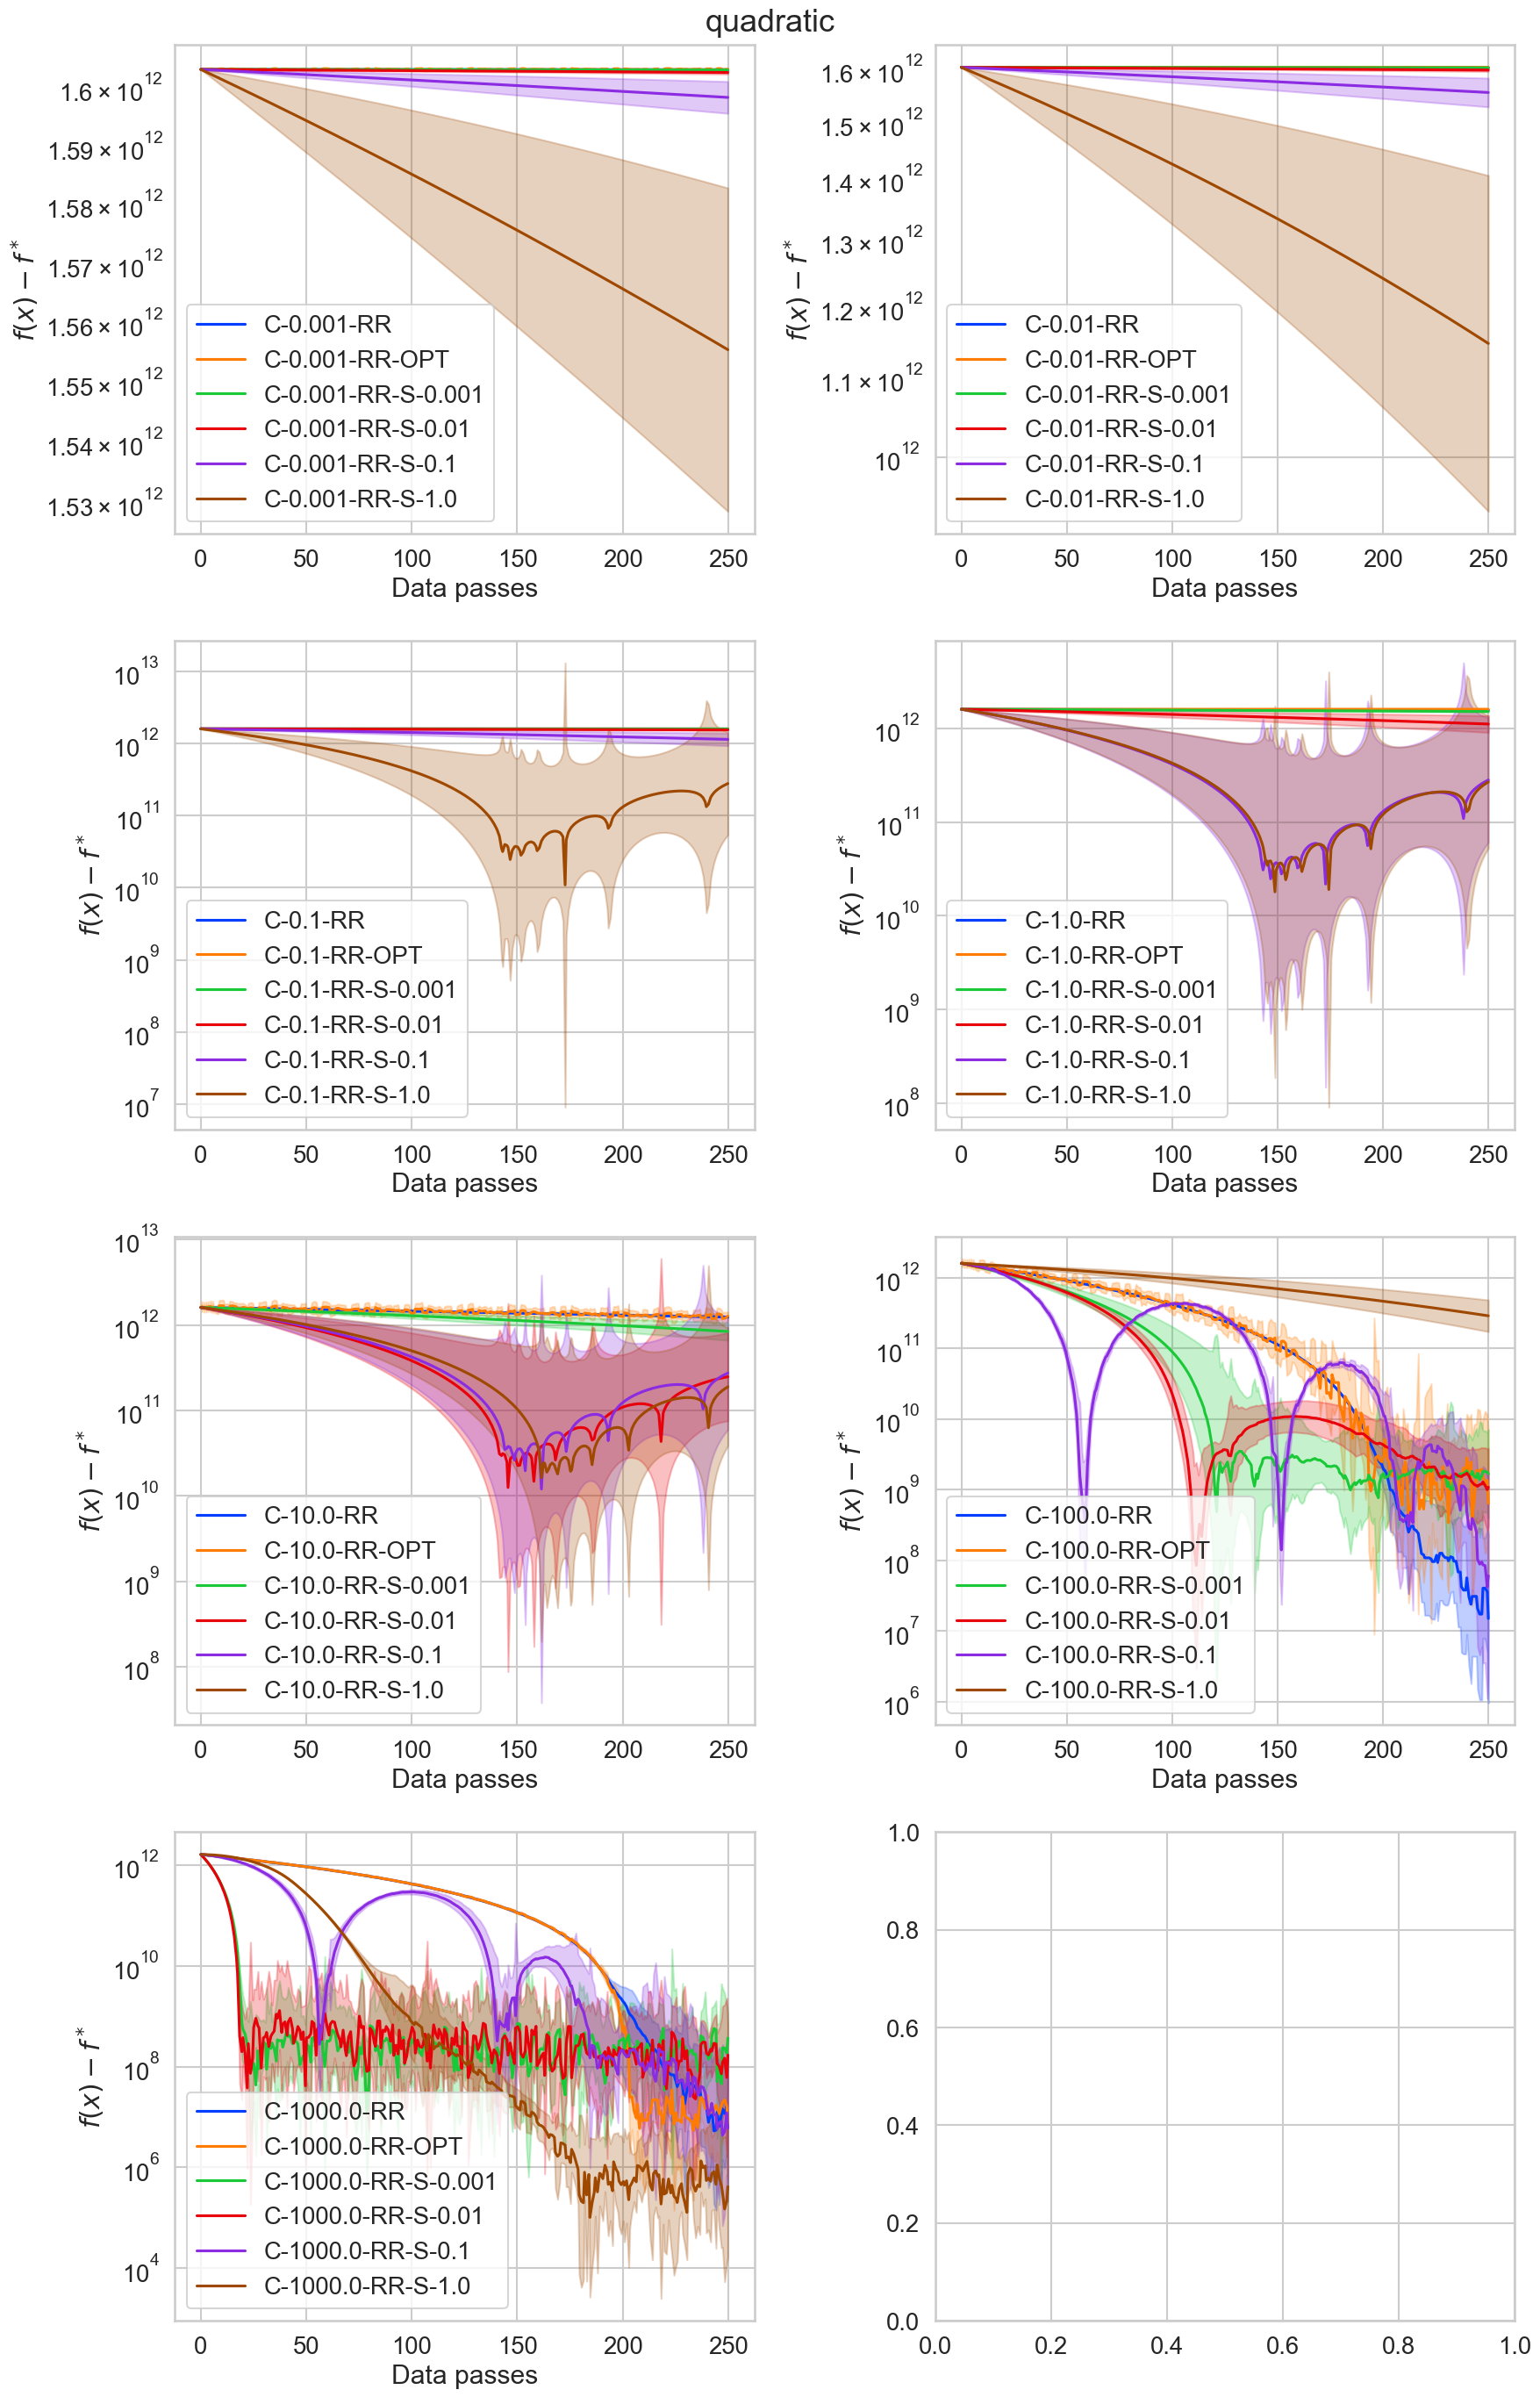

In [24]:
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_x, fig_y))
for (i, (ax, c_rr_trace, c_rr_opt_trace, clip_level)) in \
    enumerate(zip(axis.flatten(), crr_traces, crr_opt_traces, clip_level_list)):
    traces = [c_rr_trace, c_rr_opt_trace]
    labels = [f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', ',']
    for a, c_rr_shift_traces in a_crr_shift_traces_dict.items():
        traces.append(c_rr_shift_traces[i])
        labels.append(f'C-{clip_level}-RR-S-{a}')
        markers.append(',')
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_losses(f_opt=f_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
# plt.savefig(f'./plots/{dataset}/{dataset}_func_rr_opt_shift.png', dpi=300)

#### Distance to solution

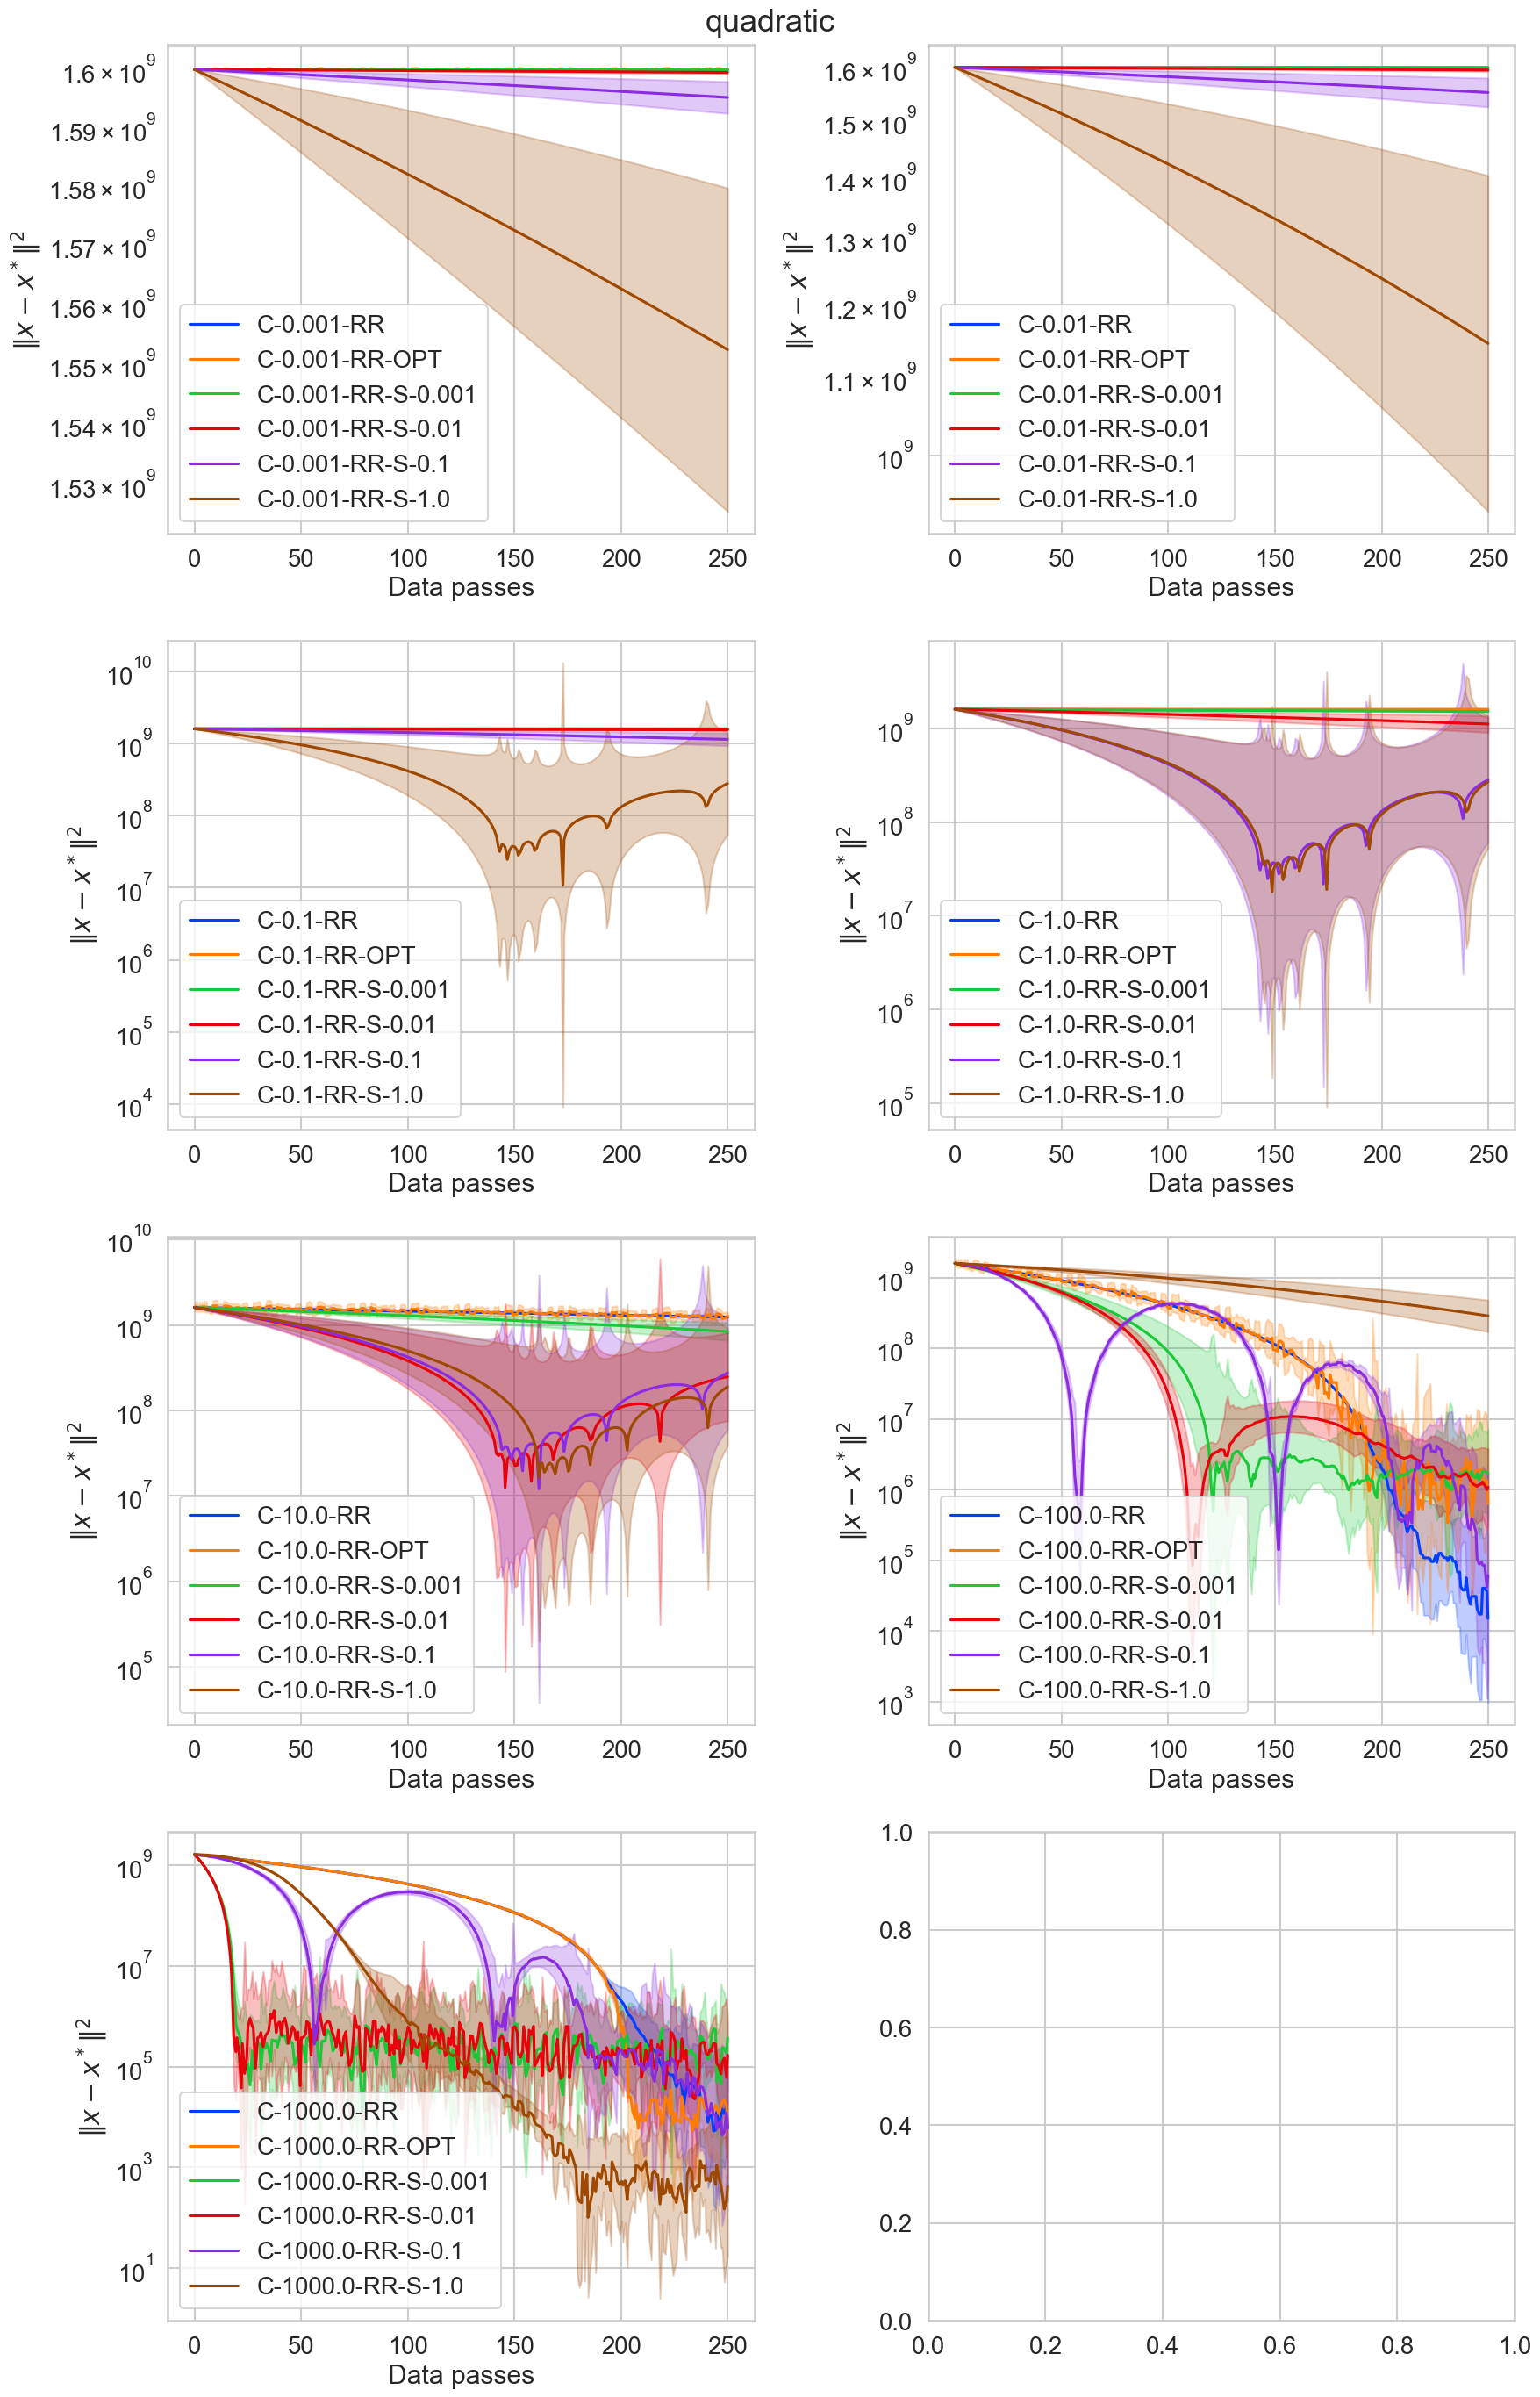

In [25]:
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_x, fig_y))
for (i, (ax, c_rr_trace, c_rr_opt_trace, clip_level)) in \
    enumerate(zip(axis.flatten(), crr_traces, crr_opt_traces, clip_level_list)):
    traces = [c_rr_trace, c_rr_opt_trace]
    labels = [f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', ',']
    for a, c_rr_shift_traces in a_crr_shift_traces_dict.items():
        traces.append(c_rr_shift_traces[i])
        labels.append(f'C-{clip_level}-RR-S-{a}')
        markers.append(',')
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_distances(x_opt=x_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
# plt.savefig(f'./plots/{dataset}/{dataset}_dist_rr_opt_shift.png', dpi=300)

# Functions spread uniformly

In [ ]:
dataset = 'quadratic'
x = np.linspace(1, 1e5, 100)
loss = Quadratic(x)
n, dim = len(x), 1
L = loss.smoothness()
# x0 = csc_matrix((dim, 1))
x0 = np.array([0.])
n_epoch = 600
batch_size = 512
# n_seeds = 2 # was set to 20 in the paper
n_seeds = 10
stoch_it = 250 * n // batch_size
trace_len = 300
trace_path = f'results/log_reg_{dataset}/'
step_size_list = np.logspace(-3, 1, 5)

In [ ]:
f_opt = loss.f_opt
x_opt = loss.x_opt

In [ ]:
def best_trace_by_step_size(traces, step_size_list):
    min_i, min_val = 0, np.inf
    for i, tr in enumerate(traces):
        if tr.loss_vals is None:
            mean_loss_val = 0
            for loss_vals in tr.loss_vals_all.values():
                mean_loss_val += loss_vals[-1]
            mean_loss_val /= len(tr.loss_vals_all)
        else:
            mean_loss_val = tr.loss_vals[-1]
        if mean_loss_val < min_val:
            min_val = mean_loss_val
            min_i = i
    
    best_trace = traces[min_i]
    best_trace.step_size = step_size_list[min_i]
    return best_trace

## Experiments

Random Reshuffling

In [ ]:
rr_traces = []
for step_size in tqdm(step_size_list):
    rr_lr0 = step_size
    rr = Shuffling(
        loss=loss, 
        lr0=rr_lr0, 
        it_max=stoch_it, 
        n_seeds=n_seeds, 
        batch_size=batch_size, 
        trace_len=trace_len
    )
    rr_trace = rr.run(x0=x0)
    rr_trace.convert_its_to_epochs(batch_size=batch_size)
    rr_trace.compute_loss_of_iterates()
    rr_traces.append(rr_trace)
rr_trace = best_trace_by_step_size(rr_traces, step_size_list)
    

  0%|          | 0/5 [00:00<?, ?it/s]

Clipped random reshuffling

In [ ]:
crr_traces = []
clip_level_list = np.logspace(-3, 2, 6)
for clip_level in tqdm(clip_level_list):
    cl_crr_traces = []
    for step_size in step_size_list:
        crr_lr0 = step_size
        crr = ClippedShuffling(
            loss=loss, 
            lr0=crr_lr0, 
            it_max=stoch_it, 
            n_seeds=n_seeds, 
            batch_size=batch_size, 
            trace_len=trace_len,
            clip_level=clip_level,
            steps_per_permutation=np.inf
        )
        crr_trace = crr.run(x0=x0)
        crr_trace.convert_its_to_epochs(batch_size=batch_size)
        crr_trace.compute_loss_of_iterates()
        crr_trace.compute_last_iterate_grad_norms()
        cl_crr_traces.append(crr_trace)
    
    best_trace = best_trace_by_step_size(cl_crr_traces, step_size_list)
    crr_traces.append(best_trace)

  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

Clipped random reshuffling Opt

In [ ]:
crr_opt_traces = []
for clip_level in tqdm(clip_level_list):
    cl_crr_opt_traces = []
    for step_size in step_size_list:
        crr_opt_lr0 = step_size
        crr_opt = ClippedShuffling(
            loss=loss, 
            lr0=crr_opt_lr0, 
            it_max=stoch_it, 
            n_seeds=n_seeds, 
            batch_size=batch_size, 
            trace_len=trace_len,
            clip_level=clip_level,
            x_opt=x_opt,
            steps_per_permutation=np.inf
        )
        crr_opt_trace = crr_opt.run(x0=x0)
        crr_opt_trace.convert_its_to_epochs(batch_size=batch_size)
        crr_opt_trace.compute_loss_of_iterates()
        crr_opt_trace.compute_last_iterate_grad_norms()
        cl_crr_opt_traces.append(crr_opt_trace)
    
    best_trace = best_trace_by_step_size(cl_crr_opt_traces, step_size_list)
    crr_opt_traces.append(best_trace)

  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

Clipping with shifts

In [ ]:
clip_level_list

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [ ]:
alpha_shift_list = step_size_list
a_crr_shift_traces_dict = {}
for alpha_shift in tqdm(alpha_shift_list):
    a_crr_shift_traces_dict[alpha_shift] = []
    for clip_level in clip_level_list:
        cl_crr_shift_traces = []

        for step_size in step_size_list:
            crr_shift_lr0 = step_size
            crr_shift = ClippedShuffling(
                loss=loss, 
                lr0=crr_shift_lr0, 
                it_max=stoch_it, 
                n_seeds=n_seeds, 
                batch_size=batch_size, 
                trace_len=trace_len,
                clip_level=clip_level,
                alpha_shift=alpha_shift,
                steps_per_permutation=np.inf
            )
            crr_shift_trace = crr_shift.run(x0=x0)
            crr_shift_trace.convert_its_to_epochs(batch_size=batch_size)
            crr_shift_trace.compute_loss_of_iterates()
            crr_shift_trace.compute_last_iterate_grad_norms()
            cl_crr_shift_traces.append(crr_shift_trace)

        best_trace = best_trace_by_step_size(cl_crr_shift_traces, step_size_list)
        a_crr_shift_traces_dict[alpha_shift].append(best_trace)

  0%|          | 0/5 [00:00<?, ?it/s]

Single reshuffling

In [ ]:
so_traces = []
for step_size in tqdm(step_size_list):
    so_lr0 = step_size
    so = Shuffling(
        loss=loss, 
        lr0=so_lr0, 
        it_max=stoch_it, 
        n_seeds=n_seeds, 
        batch_size=batch_size, 
        steps_per_permutation=np.inf, 
        trace_len=trace_len
    )
    so_trace = so.run(x0=x0)
    so_trace.convert_its_to_epochs(batch_size=batch_size)
    so_trace.compute_loss_of_iterates()
    so_traces.append(so_trace)
so_trace = best_trace_by_step_size(so_traces, step_size_list)

  0%|          | 0/5 [00:00<?, ?it/s]

SGD

In [ ]:
sgd_traces = []
for step_size in tqdm(step_size_list):
    sgd_lr0 = step_size
    sgd = Sgd(
        loss=loss,
        lr0=sgd_lr0, 
        it_max=stoch_it, 
        n_seeds=1, 
        batch_size=batch_size, 
        avoid_cache_miss=True, 
        trace_len=trace_len
    )
    sgd_trace = sgd.run(x0=x0)
    sgd_trace.convert_its_to_epochs(batch_size=batch_size)
    sgd_trace.compute_loss_of_iterates()
    sgd_traces.append(sgd_trace)
sgd_trace = best_trace_by_step_size(sgd_traces, step_size_list)

  0%|          | 0/5 [00:00<?, ?it/s]

Deterministic reshuffling

In [ ]:
ig_traces = []
for step_size in tqdm(step_size_list):
    ig_lr0 = step_size
    ig = Ig(
        loss=loss, 
        lr0=ig_lr0, 
        it_max=stoch_it, 
        batch_size=batch_size, 
        trace_len=trace_len
    )
    ig_trace = ig.run(x0=x0)
    ig_trace.convert_its_to_epochs(batch_size=batch_size)
    ig_trace.compute_loss_of_iterates()
    ig_traces.append(ig_trace)
ig_trace = best_trace_by_step_size(ig_traces, step_size_list)

  0%|          | 0/5 [00:00<?, ?it/s]

## Plots

In [ ]:
ncols = 2 if len(clip_level_list) >= 2 else 1
nrows = int(np.ceil(len(clip_level_list) / 2))

### Everything with CRR without shifts

#### Functional residual

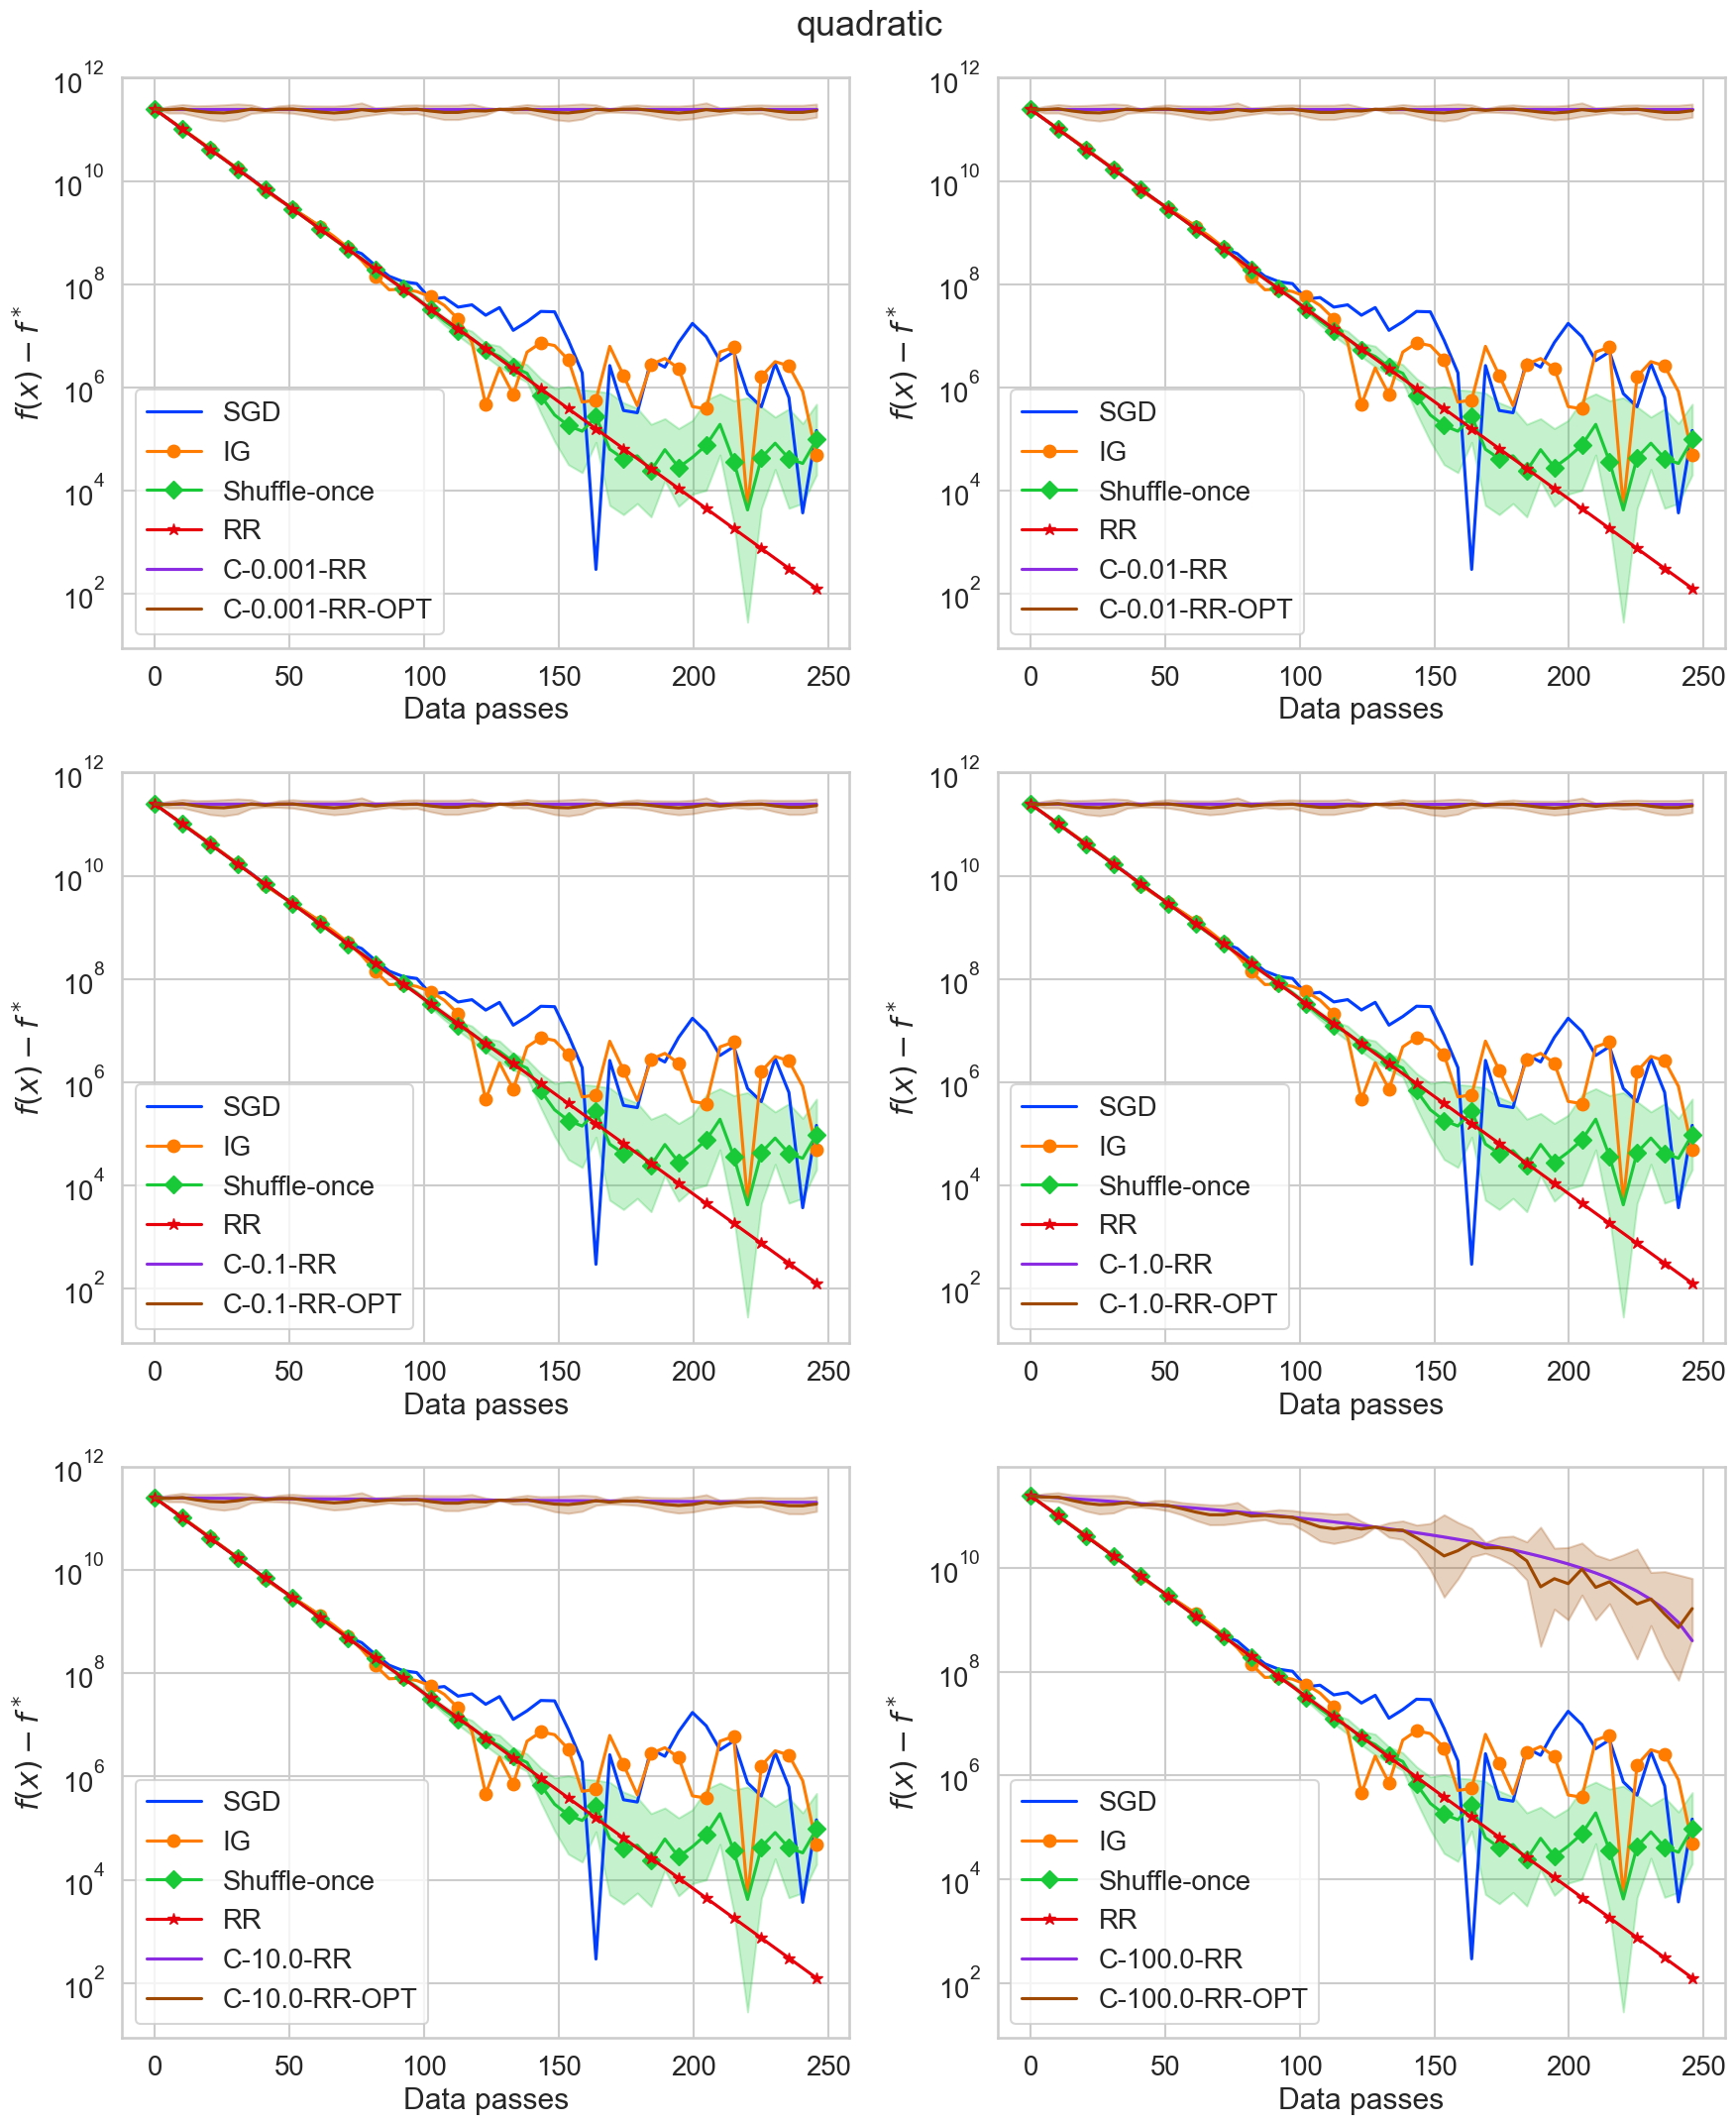

In [ ]:
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 22))
for ax, c_rr_trace, c_rr_opt_trace, clip_level in zip(axis.flatten(), crr_traces, crr_opt_traces, clip_level_list):
    traces = [sgd_trace, ig_trace, so_trace, rr_trace, c_rr_trace, c_rr_opt_trace]
    labels = ['SGD', 'IG', 'Shuffle-once', 'RR', f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', 'o', 'D', '*', ',', ',']
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_losses(f_opt=f_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
# plt.savefig(f'./plots/{dataset}_func.png', dpi=300)

#### Distance to solution

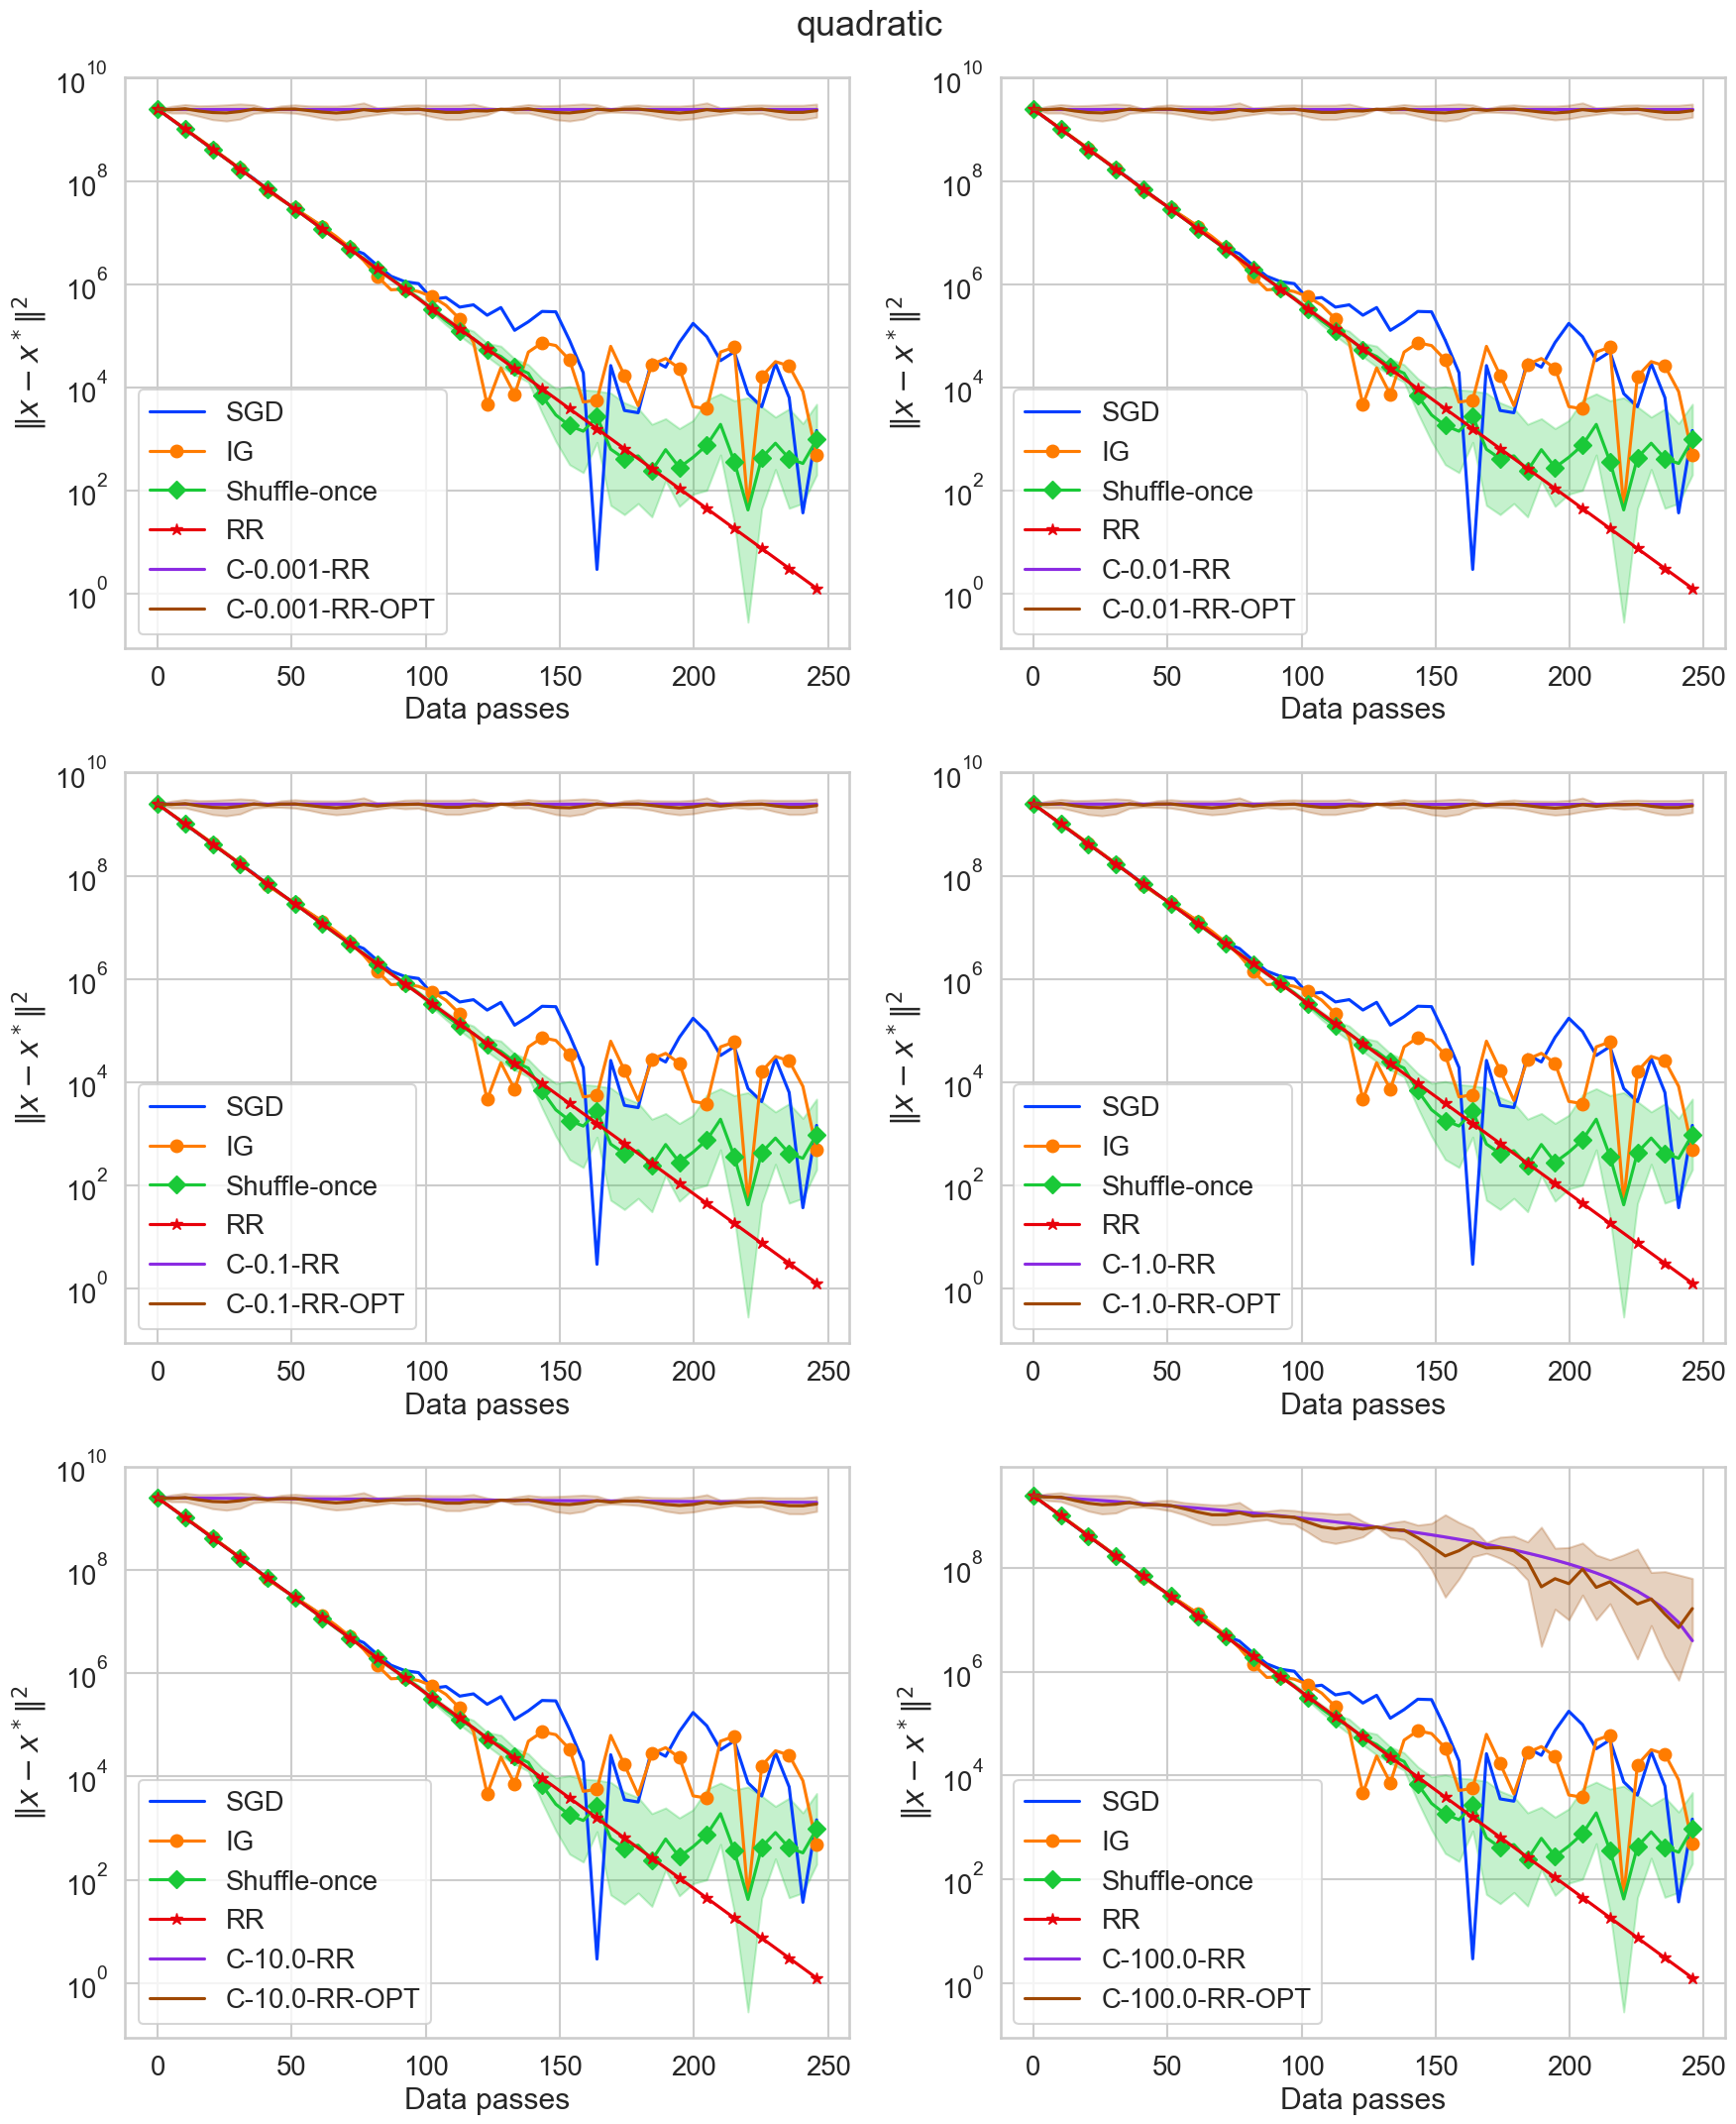

In [ ]:
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 22))
for ax, c_rr_trace, c_rr_opt_trace, clip_level in zip(axis.flatten(), crr_traces, crr_opt_traces, clip_level_list):
    traces = [sgd_trace, ig_trace, so_trace, rr_trace, c_rr_trace, c_rr_opt_trace]
    labels = ['SGD', 'IG', 'Shuffle-once', 'RR', f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', 'o', 'D', '*', ',', ',']
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_distances(x_opt=x_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
# plt.savefig(f'./plots/{dataset}_dist.png', dpi=300)

### Only CRR

#### Functional residual

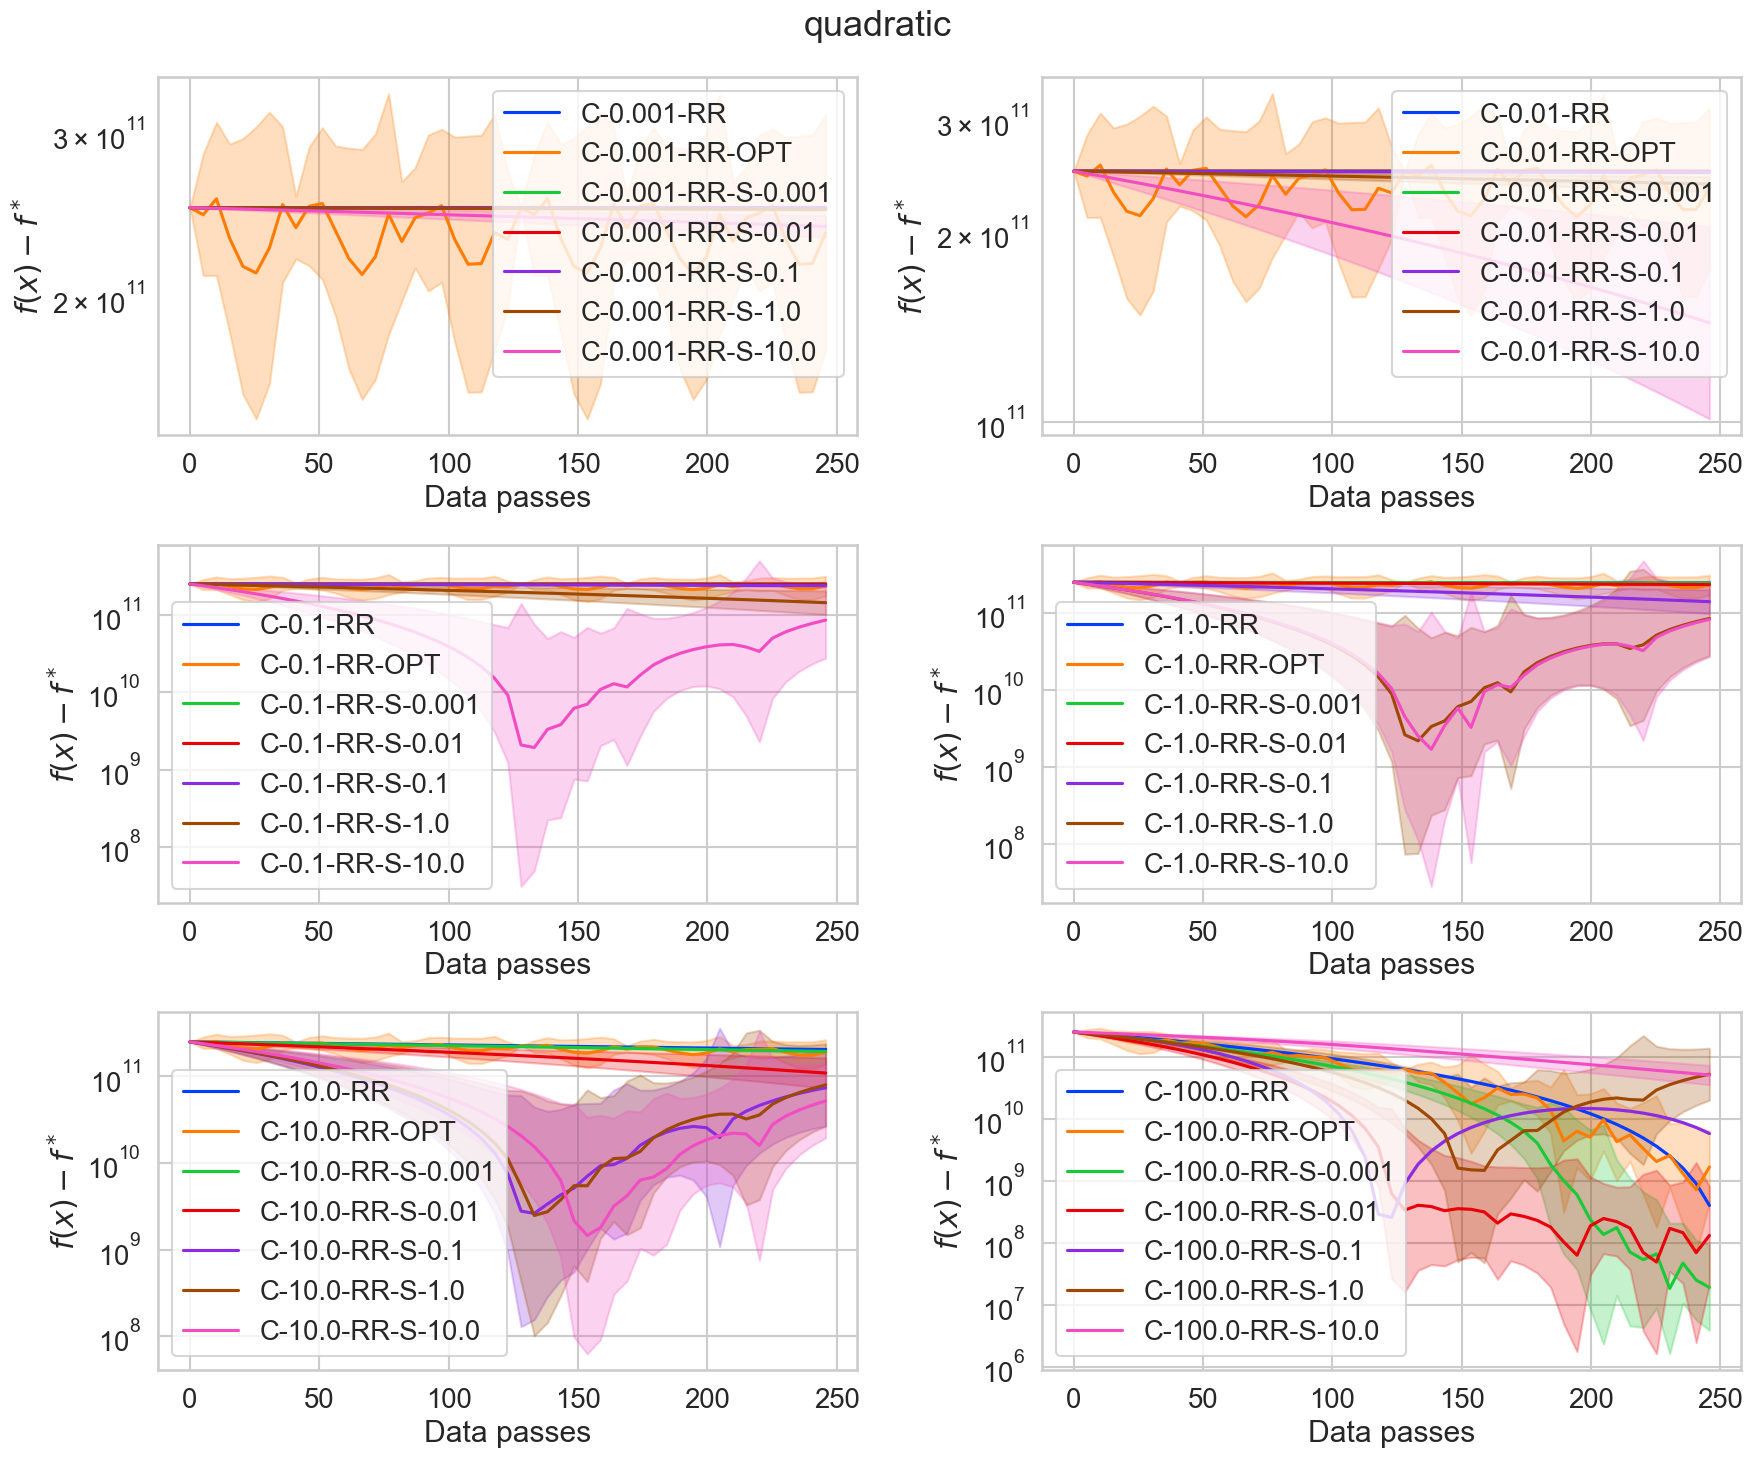

In [ ]:
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 15))
for (i, (ax, c_rr_trace, c_rr_opt_trace, clip_level)) in \
    enumerate(zip(axis.flatten(), crr_traces, crr_opt_traces, clip_level_list)):
    traces = [c_rr_trace, c_rr_opt_trace]
    labels = [f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', ',']
    for a, c_rr_shift_traces in a_crr_shift_traces_dict.items():
        traces.append(c_rr_shift_traces[i])
        labels.append(f'C-{clip_level}-RR-S-{a}')
        markers.append(',')
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_losses(f_opt=f_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
# plt.savefig(f'./plots/{dataset}_func_rr_opt_shift.png', dpi=300)

#### Distance to solution

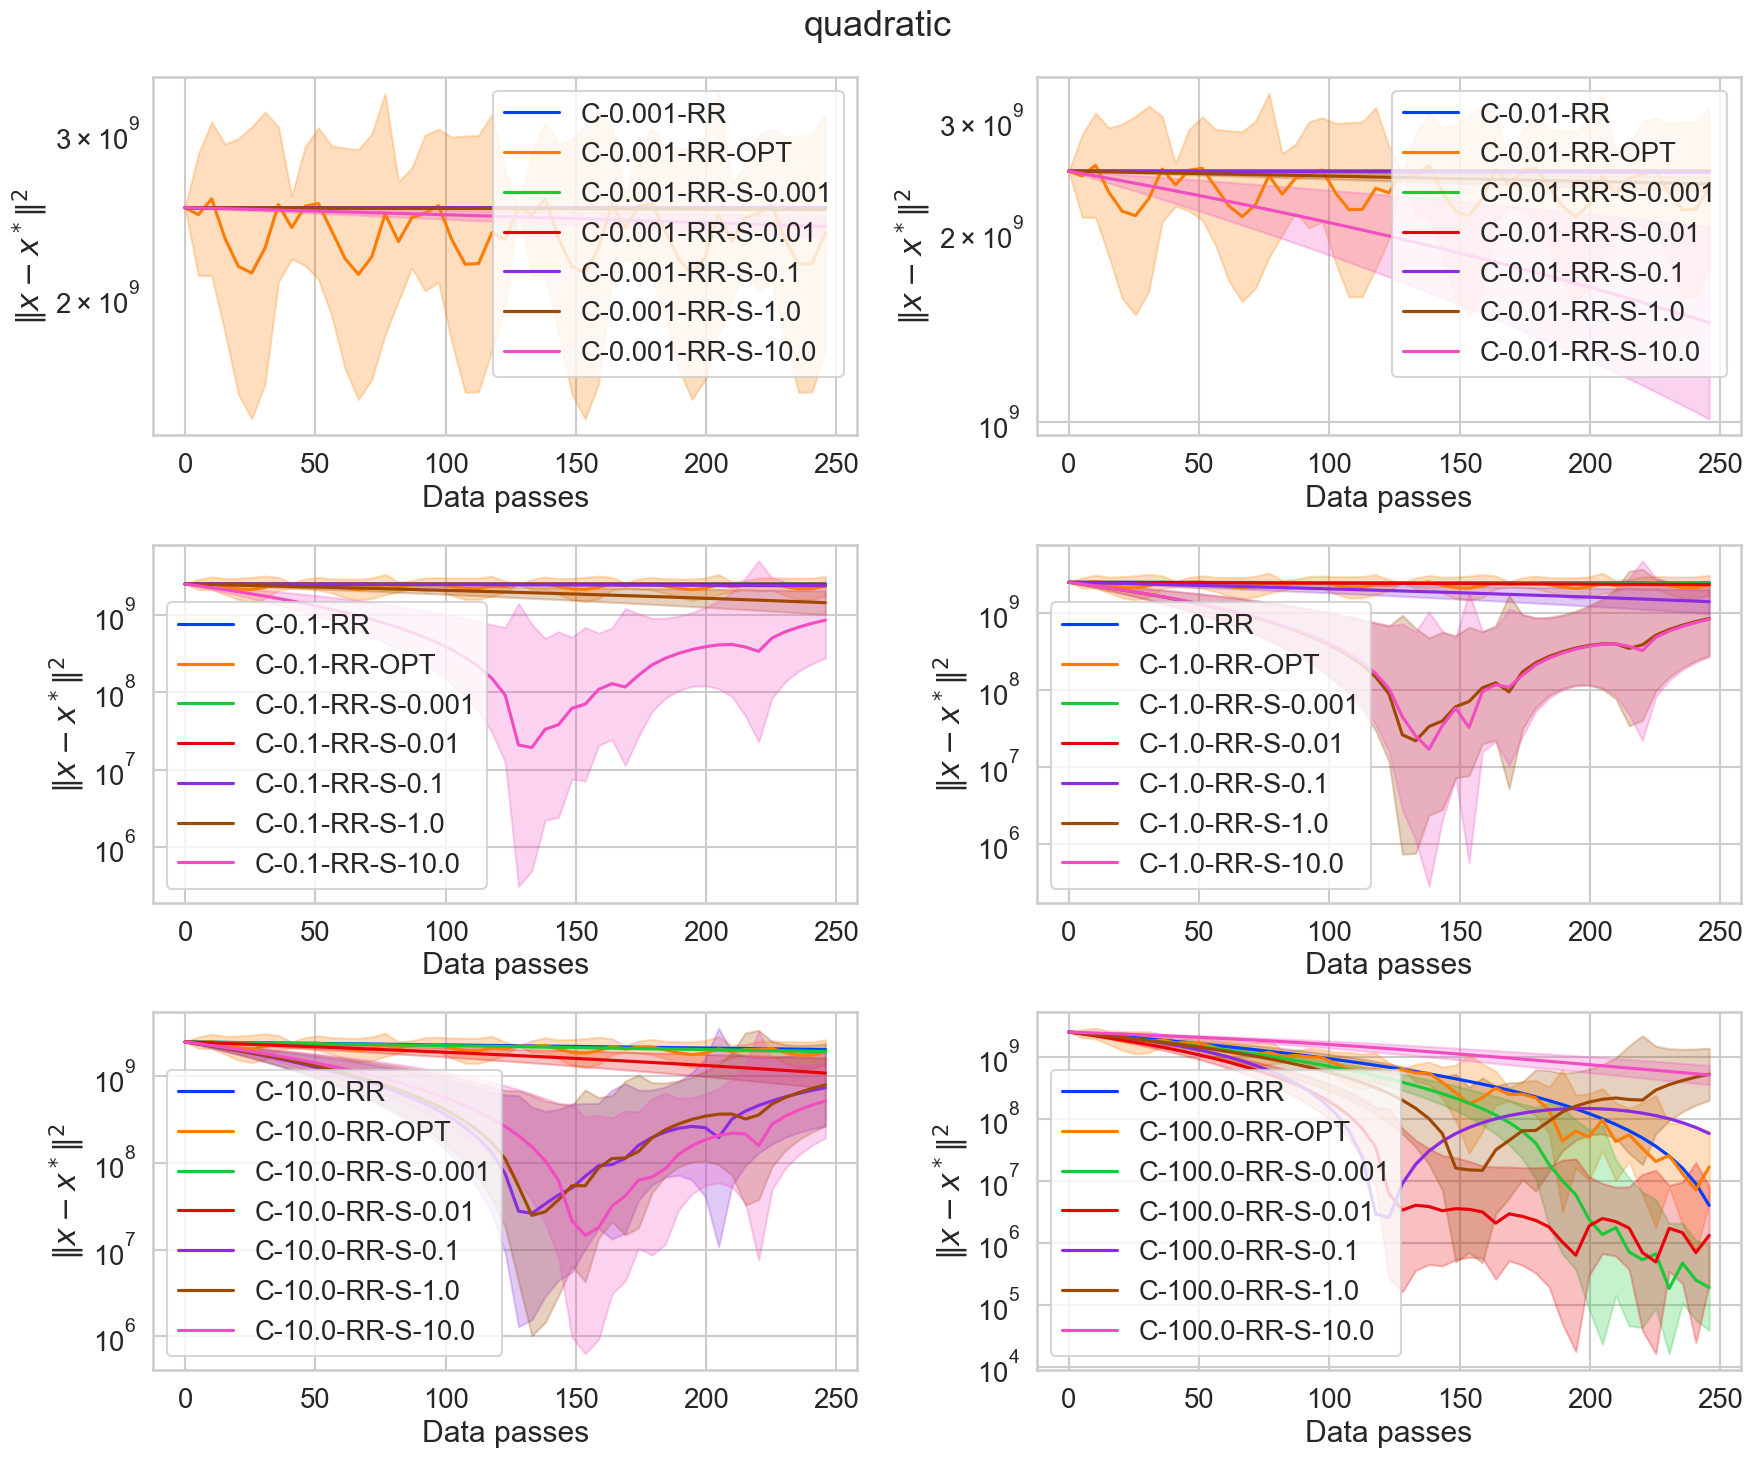

In [ ]:
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 15))
for (i, (ax, c_rr_trace, c_rr_opt_trace, clip_level)) in \
    enumerate(zip(axis.flatten(), crr_traces, crr_opt_traces, clip_level_list)):
    traces = [c_rr_trace, c_rr_opt_trace]
    labels = [f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', ',']
    for a, c_rr_shift_traces in a_crr_shift_traces_dict.items():
        traces.append(c_rr_shift_traces[i])
        labels.append(f'C-{clip_level}-RR-S-{a}')
        markers.append(',')
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_distances(x_opt=x_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
# plt.savefig(f'./plots/{dataset}_dist_rr_opt_shift.png', dpi=300)